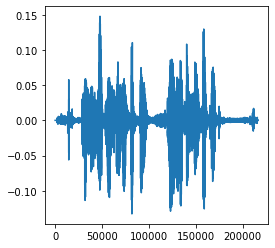

In [153]:
import librosa
import matplotlib.pyplot as plt

signal, sr = librosa.load('C:/Users/Yashvi/Desktop/TestCases/TestCase40.wav', sr=44100)
plt.figure(figsize=(4, 4))
plt.plot(signal)

In [154]:
import IPython.display as ipd
ipd.Audio('C:/Users/Yashvi/Desktop/TestCases/TestCase1.wav')

In [155]:
import pandas as pd
import os
import librosa

audio_dataset_path='C:/Users/Yashvi/Desktop/TestCases/'
metadata=pd.read_csv('C:/Users/Yashvi/Desktop/final_dataset.csv')
metadata.head()

,file_name,gender,age_group,state,bpm,heart_rate
0,TestCase1.wav,F,20-29,tired,80,normal
1,TestCase2.wav,M,20-29,tired,92,normal
2,TestCase3.wav,M,20-29,after_workout,122,abnormal
3,TestCase4.wav,F,20-29,tired,99,abnormal
4,TestCase5.wav,M,20-29,happy,102,normal


In [156]:
import numpy as np
import random

def manipulate0(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def manipulate1(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

def manipulate2(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def manipulate3(data, speed_factor):
    return librosa.effects.time_stretch(data, speed_factor)

In [157]:
import os

import librosa
from librosa.core.convert import mel_frequencies
import numpy as np
from tqdm import tqdm

kwargs = {"htk": True, "norm": "slaney"}

def switch_function(signal,sr):
    n = random.randint(0,3)
    M0 = [.0050,.0015,.0025,.0060,.0040]
    M1 = [0.1,0.2,0.15,0.25,0.3]
    M2 = [0.5,1,1.5,2,2.5]
    M3 = [0.5,0.75,1,1.15,1.25]
    signal={
        0: manipulate0(signal,random.choice(M0)),
        1: manipulate1(signal,sr,random.choice(M1),'both'),
        2: manipulate2(signal,sr,random.choice(M2)),
        3: manipulate3(signal,random.choice(M3))
    }
    return signal.get(n,"Invalid")


def features_extractor(signal,sr):
    preemphasized_signal = librosa.effects.preemphasis(signal, coef=0.95)
    mel_spectrogram = librosa.feature.melspectrogram(
        y=preemphasized_signal,
        sr=44100,
        n_mels=42,
        n_fft=512,
        hop_length=100,
        win_length=256,
        window="hann",
        center=True,
        pad_mode="reflect",
        power=2.0,
        **kwargs
    )

    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), n_mfcc=12, dct_type=2)
    mfcc_scaled_features = np.mean(mfcc.T, axis=0)

    return [mfcc_scaled_features, mfcc]



extracted_features = []
spectogram_data = []
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), str(row["file_name"]))
    gender_labels = row["gender"]
    age_group_labels = row["age_group"]
    state_labels = row["state"]
    bpm_labels = row["bpm"]
    heart_rate_labels = row["heart_rate"]
    signal, sr = librosa.load(file_name, sr=44100)
    data1 = features_extractor(signal,sr)
    signal1 = switch_function(signal,sr)
    data2 = features_extractor(signal1,sr)
    signal2 = switch_function(signal,sr)
    data3 = features_extractor(signal2,sr)
    spectogram_data.append(data1[1])
    extracted_features.append(
        [data1[0], gender_labels, age_group_labels, state_labels, bpm_labels, heart_rate_labels]
    )
    extracted_features.append(
        [data2[0], gender_labels, age_group_labels, state_labels, heart_rate_labels]
    )
    extracted_features.append(
        [data3[0], gender_labels, age_group_labels, state_labels, heart_rate_labels]
    )

one_hot = pd.get_dummies(metadata["gender"])
# Drop column B as it is now encoded
metadata = metadata.drop("gender", axis=1)
# Join the encoded df
metadata = metadata.join(one_hot)

newstates= []
states = metadata["state"].to_list()
for state in states:
    newstates.append(
        state.lower().strip()
    )
metadata = metadata.drop("state", axis=1)
metadata['state'] = newstates

one_hot = pd.get_dummies(metadata["state"])
metadata = metadata.drop("state", axis=1)
metadata = metadata.join(one_hot)

one_hot = pd.get_dummies(metadata["age_group"])
metadata = metadata.drop("age_group", axis=1)
metadata = metadata.join(one_hot)

heart_rates = metadata["heart_rate"].to_list()

metadata = metadata.drop("heart_rate", axis=1)
metadata = metadata.drop("file_name", axis=1)

y = metadata["bpm"]
metadata = metadata.drop("bpm",axis=1)
metadata = metadata.join(y)


remaining_features = metadata.values

result = []

for i in range(len(extracted_features)):
    features = extracted_features[i][0].tolist()
    new = []

    new += extracted_features[i][0].tolist()
    new += remaining_features[i%104].tolist()
    new.append(heart_rates[i%104])

    result.append(new)

names = []
for i in range(1,13):
    names.append(f"mfcc_{i}")
s = "F 	M 	after_workout 	happy 	neutral 	relaxed 	stressed 	tired 	20-29 	30-39 	40-49 	50-59 	60-69 	bpm"

names = names + s.strip().split()
names.append("heart_rate")

pd.DataFrame(result, columns=names).to_csv("save.csv", index=False)

104it [03:10,  1.83s/it]


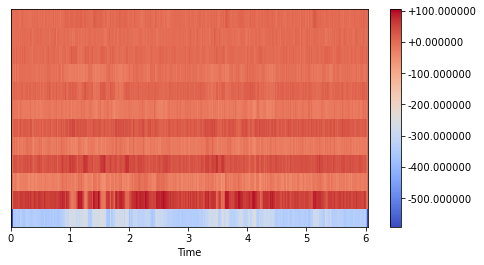

In [158]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(8,4))
librosa.display.specshow(spectogram_data[1],x_axis = "time",sr=44100,hop_length=100)
plt.colorbar(format="%+2f")
plt.show() 

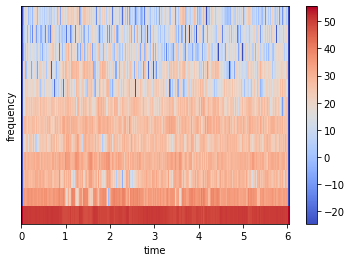

In [159]:
log_spect = librosa.amplitude_to_db(spectogram_data[1])
plt.figure(figsize=(6,4))
librosa.display.specshow(log_spect,x_axis = "time",sr=44100,hop_length=100)
plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar()
plt.show()

In [52]:
extracted_features_df = pd.read_csv("save.csv")
extracted_features_df.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,relaxed,stressed,tired,20-29,30-39,40-49,50-59,60-69,bpm,heart_rate
0,-424.305389,28.069408,-0.938178,34.194496,-15.378820,13.257497,-15.704871,3.350605,-6.099052,2.114506,...,0,0,1,1,0,0,0,0,80,normal
1,-314.642029,-39.653580,10.835461,6.615831,1.060621,-1.020874,-3.054082,-2.942393,-1.588397,-0.893848,...,0,0,1,1,0,0,0,0,92,normal
2,-441.211884,28.592348,-3.832582,35.906487,-18.138018,14.292966,-17.945202,5.317703,-7.802907,3.568249,...,0,0,0,1,0,0,0,0,122,abnormal
3,-320.139313,56.085464,-25.127012,35.068516,-19.841785,25.081285,-18.262539,7.980090,-10.084351,2.464752,...,0,0,1,1,0,0,0,0,99,abnormal
4,-320.065948,56.024689,-25.126669,35.085400,-19.853678,25.083719,-18.260611,7.979133,-10.080998,2.453858,...,0,0,0,1,0,0,0,0,102,normal


In [132]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df.iloc[:, :-1].values.tolist())
y=np.array(extracted_features_df.iloc[:, -1].values.tolist())

In [133]:
X.shape

(312, 26)

In [134]:
### Label Encoding
y=np.array(pd.get_dummies(y))

In [135]:
y.shape

(312, 2)

In [143]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [137]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [121]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [145]:
num_labels=y.shape[1]
print(num_labels)

2


In [146]:
model=Sequential()
###first layer
model.add(Dense(50,input_shape=(26,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
###second layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.2))
###third layer
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.2))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [139]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 50)                1350      
_________________________________________________________________
activation_20 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               5100      
_________________________________________________________________
activation_21 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)               

In [148]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [149]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 50
num_batch_size = 5

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)

start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
50/50 [==============================] - 1s 5ms/step - loss: 17.4251 - accuracy: 0.5236 - val_loss: 2.8621 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from inf to 2.86206, saving model to saved_models\audio_classification.hdf5
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 5.7067 - accuracy: 0.5911 - val_loss: 0.8779 - val_accuracy: 0.7460

Epoch 00002: val_loss improved from 2.86206 to 0.87791, saving model to saved_models\audio_classification.hdf5
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 5.0663 - accuracy: 0.5993 - val_loss: 1.1730 - val_accuracy: 0.3175

Epoch 00003: val_loss did not improve from 0.87791
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 3.0437 - accuracy: 0.5133 - val_loss: 1.4410 - val_accuracy: 0.2540

Epoch 00004: val_loss did not improve from 0.87791
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 1.9459 - accuracy: 0.6524 - val_loss: 1.734

50/50 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.7198 - val_loss: 0.6108 - val_accuracy: 0.7460

Epoch 00040: val_loss did not improve from 0.60395
Epoch 41/50
50/50 [==============================] - 0s 2ms/step - loss: 0.6164 - accuracy: 0.6825 - val_loss: 0.6093 - val_accuracy: 0.7460

Epoch 00041: val_loss did not improve from 0.60395
Epoch 42/50
50/50 [==============================] - 0s 2ms/step - loss: 0.6635 - accuracy: 0.6646 - val_loss: 0.6104 - val_accuracy: 0.7460

Epoch 00042: val_loss did not improve from 0.60395
Epoch 43/50
50/50 [==============================] - 0s 2ms/step - loss: 0.6948 - accuracy: 0.6562 - val_loss: 0.6075 - val_accuracy: 0.7460

Epoch 00043: val_loss did not improve from 0.60395
Epoch 44/50
50/50 [==============================] - 0s 2ms/step - loss: 0.6615 - accuracy: 0.6473 - val_loss: 0.6073 - val_accuracy: 0.7460

Epoch 00044: val_loss did not improve from 0.60395
Epoch 45/50
50/50 [============================

In [150]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7460317611694336


In [151]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [152]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, y_pred)

array([[[47,  0],
        [16,  0]],

       [[ 0, 16],
        [ 0, 47]]], dtype=int64)